In [5]:
import pandas as pd
import json
import numpy as np
from plotnine import *
import plotnine
from kmodes.kprototypes import KPrototypes
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm

# load json and view in dataframe
path_to_json_file = "d:/delman.io/youtube-categories.json"


json_file = open(path_to_json_file, 'r')
loaded_json = json_file.read()
json_file.close()
df_json = pd.read_json(loaded_json)
df_json_snippet = pd.json_normalize(df_json["snippet"], sep = ",")
df_json2 = df_json[['kind', 'etag', 'id']]
df_json_final = pd.merge(df_json2, df_json_snippet, left_index=True, right_index=True)

#load parquet
path_to_parquet_file = "d:/delman.io/youtube-videos.parquet"

df_parquet = pd.read_parquet(path_to_parquet_file, engine='pyarrow')
# print('Dimension data: {} rows and {} columns'.format(len(df_parquet), len(df_parquet.columns)))
df_join = pd.merge(df_parquet, df_json_final, left_on='category_id', right_on='id')
df_join_final = df_join.loc[:,('title_x', 'channel_title', 'title_y', 'tags', 'views', 'likes', 'dislikes', 'comment_count','description')]
df_join_final.rename(columns = {'title_x':'video_title', 'title_y':'category_title'}, inplace = True)

# The distribution of category_title
df_category_title = pd.DataFrame(df_join_final['category_title'].value_counts()).reset_index()
df_category_title['Percentage'] = df_category_title['category_title'] / df_join_final['category_title'].value_counts().sum()
df_category_title.rename(columns = {'index':'category_title', 'category_title':'Total'}, inplace = True)
df_category_title = df_category_title.sort_values('Total', ascending = True).reset_index(drop = True)

# The dataframe
df_category_title = df_join_final.groupby('category_title').agg({
    'category_title': 'count',
    'views': 'mean',
    'likes': 'mean',
    'dislikes': 'mean',
    'comment_count': 'mean'
    }
).rename(columns = {'category_title': 'Total'}).reset_index().sort_values('Total', ascending = True)

# plotnine.options.figure_size = (8, 4.8)
# print(
#     ggplot(data = df_category_title)+
#     geom_bar(aes(x = 'category_title',
#                  y = 'Total'),
#              fill = np.where(df_category_title['category_title'] == 'Entertainment', '#981220', '#80797c'),
#              stat = 'identity')+
#     geom_text(aes(x = 'category_title',
#                    y = 'Total',
#                    label = 'Total'),
#                size = 10,
#                nudge_y = 350)+
#     labs(title = 'Video Category that has the highest count')+
#     xlab('category_title')+
#     ylab('Frequency')+
#     scale_x_discrete(limits = df_category_title['category_title'].tolist())+
#     theme_minimal()+
#     coord_flip()
# )

df_join_final['video_title']    = df_join_final['video_title'].astype(str)
df_join_final['channel_title']  = df_join_final['channel_title'].astype(str)
df_join_final['category_title'] = df_join_final['category_title'].astype(str)
df_join_final['tags']           = df_join_final['tags'].astype(str)
df_join_final['description']    = df_join_final['description'].astype(str)
df_join_final['views']          = df_join_final['views'].astype(float)
df_join_final['likes']          = df_join_final['likes'].astype(float)
df_join_final['dislikes']       = df_join_final['dislikes'].astype(float)
df_join_final['comment_count']  = df_join_final['comment_count'].astype(float)

catColumnsPos = [df_join_final.columns.get_loc(col) for col in list(df_join_final.select_dtypes('object').columns)]
# print('Categorical columns           : {}'.format(list(df_join_final.select_dtypes('object').columns)))
# print('Categorical columns position  : {}'.format(catColumnsPos))

dfMatrix = df_join_final.to_numpy()
cost = []
for cluster in tqdm(range(1, 6)):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
    kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
    cost.append(kprototype.cost_)
    print('Cluster initiation: {}'.format(cluster))
    


 20%|██        | 1/5 [01:30<06:02, 90.55s/it]

Cluster initiation: 1


 40%|████      | 2/5 [04:10<06:33, 131.27s/it]

Cluster initiation: 2


 60%|██████    | 3/5 [08:12<06:04, 182.08s/it]

Cluster initiation: 3


 80%|████████  | 4/5 [12:06<03:22, 202.30s/it]

Cluster initiation: 4


100%|██████████| 5/5 [19:22<00:00, 232.55s/it]

Cluster initiation: 5


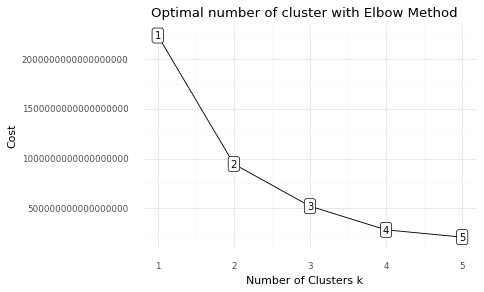

<ggplot: (165827346146)>

In [6]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 6), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [7]:

# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([1, 1, 1, ..., 1, 1, 1], dtype=uint16)

In [8]:
# Cluster centorid
kprototype.cluster_centroids_


array([['106243685.98979592', '2825262.4591836734', '222028.72448979592',
        '376674.4081632653',
        'Childish Gambino - This Is America (Official Video)',
        'ChildishGambinoVEVO', 'Music',
        'Childish Gambino|"Rap"|"This Is America"|"mcDJ Recording/RCA Records"',
        '“This is America” by Childish Gambino http://smarturl.it/TcIgADirector: Hiro MuraiProducer: Jason Cole of Doomsday with Ibra Ake and Fam Rothstein of Wolf + Rothsteintour tickets and merchandise available at childishgambino.com'],
       ['1365534.2113553484', '47735.44484400324', '2054.474827795786',
        '5482.065083063209',
        'WE MADE OUR MOM CRY...HER DREAM CAME TRUE!', 'ESPN',
        'Entertainment', '[none]', 'None'],
       ['23725366.094644167', '645116.8239178283', '36017.78283198826',
        '67863.7461482025', 'Daddy Yankee - Hielo (Video Oficial)',
        'Dude Perfect', 'Music', '[none]',
        'Daddy Yankee - Hielo (Video Oficial)Spotify: https://goo.gl/LPP4j9Apple Mu

In [9]:
# Check the iteration of the clusters created
kprototype.n_iter_


17

In [10]:
# Check the cost of the clusters created
kprototype.cost_

5.209146474296547e+17

In [13]:
# Add the cluster to the dataframe
df_join_final['Cluster Labels'] = kprototype.labels_
df_join_final['Segment'] = df_join_final['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})
# Order the cluster
df_join_final['Segment'] = df_join_final['Segment'].astype('category')
df_join_final['Segment'] = df_join_final['Segment'].cat.reorder_categories(['First','Second','Third'])
df_join_final

,video_title,channel_title,category_title,tags,views,likes,dislikes,comment_count,description,Cluster Labels,Segment
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,SHANtell martin,748374.0,57527.0,2966.0,15954.0,SHANTELL'S CHANNEL - https://www.youtube.com/s...,1,Second
1,Me-O Cats Commercial,Nobrand,People & Blogs,"cute|""cats""|""thai""|""eggs""",98966.0,2486.0,184.0,532.0,Kittens come out of the eggs in a Thai commerc...,1,Second
2,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,People & Blogs,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053.0,4451.0,1772.0,895.0,Subscribe for weekly videos ▶ http://bit.ly/sj...,1,Second
3,BLIND(folded) CAKE DECORATING CONTEST (with Mo...,Grace Helbig,People & Blogs,"itsgrace|""funny""|""comedy""|""vlog""|""grace""|""helb...",197062.0,7250.0,217.0,456.0,Molly is an god damn amazing human and she cha...,1,Second
4,Wearing Online Dollar Store Makeup For A Week,Safiya Nygaard,People & Blogs,wearing online dollar store makeup for a week|...,2744430.0,115426.0,1110.0,6541.0,I found this online dollar store called ShopMi...,1,Second
...,...,...,...,...,...,...,...,...,...,...,...
40944,Game of Zones - S5:E5: The Isle of Van Gundy,Bleacher Report,Shows,"bleacher report|""br""|""nba""|""Stan Van Gundy""|""J...",1324482.0,22413.0,608.0,1644.0,"On an island full of Van Gundys, Stan gets tal...",1,Second
40945,Game of Zones - S5:E5: The Isle of Van Gundy,Bleacher Report,Shows,"bleacher report|""br""|""nba""|""Stan Van Gundy""|""J...",1332252.0,22461.0,610.0,1648.0,"On an island full of Van Gundys, Stan gets tal...",1,Second
40946,Game of Zones - S5:E5: The Isle of Van Gundy,Bleacher Report,Shows,"bleacher report|""br""|""nba""|""Stan Van Gundy""|""J...",1340039.0,22504.0,615.0,1648.0,"On an island full of Van Gundys, Stan gets tal...",1,Second
40947,Game of Zones - S5:E5: The Isle of Van Gundy,Bleacher Report,Shows,"bleacher report|""br""|""nba""|""Stan Van Gundy""|""J...",1345086.0,22542.0,615.0,1649.0,"On an island full of Van Gundys, Stan gets tal...",1,Second


In [15]:
df_join_final.dtypes
# df_finals_agg = df_join_final.groupby(['video_title', 'tags', 'description', 'channel_title', 'category_title', 'Cluster Labels', 'Segment'])[['views', 'likes', 'dislikes', 'comment_count']].mean()
# df_finals_agg

video_title         object
channel_title       object
category_title      object
tags                object
views              float64
likes              float64
dislikes           float64
comment_count      float64
description         object
Cluster Labels      uint16
Segment           category
dtype: object

In [17]:
# Cluster interpretation
df_join_final.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
df_join_final.groupby('Segment').agg(
    {
        'Total':'count',
        'channel_title': lambda x: x.value_counts().index[0],
        'category_title': lambda x: x.value_counts().index[0],
        'tags': lambda x: x.value_counts().index[0],
        'views': 'mean',
        'likes': 'mean',
        'dislikes': 'mean',
        'comment_count': 'mean'
    }
).reset_index()

,Segment,Total,channel_title,category_title,tags,views,likes,dislikes,comment_count
0,First,98,ChildishGambinoVEVO,Music,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",1.062437e+08,2.825262e+06,222028.724490,376674.408163
1,Second,39488,ESPN,Entertainment,[none],1.365534e+06,4.773544e+04,2054.474828,5482.065083
2,Third,1363,Dude Perfect,Music,[none],2.372537e+07,6.451168e+05,36017.782832,67863.746148
